Задача

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 

Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 

После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

Метод простой, гарантируется, что при приличном размере выборки можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже).

In [30]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
#import swifter # Ускорялка метода apply
from scipy import stats # Статистика
%matplotlib inline

In [31]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

In [32]:
# выгрузим из Кликхауса необходимые данные
q = """
    SELECT 
          exp_group,
          user_id,
          sum(action = 'like') as likes,
          sum(action = 'view') as views,
          likes / views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
            and exp_group in (2, 1)
    GROUP BY exp_group, user_id
    
"""

In [33]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [34]:
# Загрузим датасет
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [35]:
#Убедимся, что юзеров одинаковое +- количество в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [36]:
# посчитаем общий CTR в контрольной группе
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [37]:
# посчитаем новую метрику по формуле 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
df['linear_likes'] = df.likes - global_ctr_1/df.views 

In [38]:
global_ctr_1 

0.20802680490126244

In [39]:
df.head()

,exp_group,user_id,likes,views,ctr,linear_likes
0,1,109963,3,15,0.200000,2.986132
1,1,26117,32,141,0.226950,31.998525
2,1,138232,18,73,0.246575,17.997150
3,1,26295,33,122,0.270492,32.998295
4,1,18392,7,32,0.218750,6.993499


In [40]:
#увеличим размер в сиборне
sns.set(rc={'figure.figsize':(11.7,8.27)})

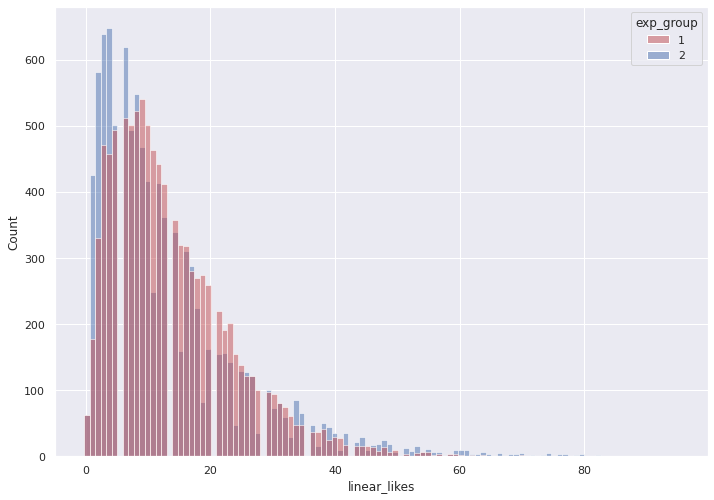

In [47]:
# посмотрим на распределение новой метрики до теста
groups = sns.histplot(data = df, 
              x='linear_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

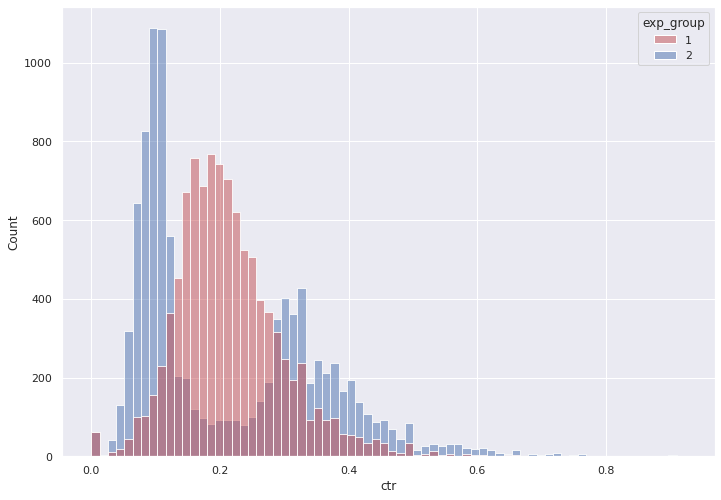

In [43]:
# посмотрим на распределение ctr до теста
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [11]:
# проведем т-тест
results = stats.ttest_ind(df[df.exp_group == 1].linear_likes,
                df[df.exp_group == 2].linear_likes,
                equal_var=False)
print('p-value:', results.pvalue)
print('statistic:', results.statistic)

p-value: 6.985814230247977e-06
statistic: 4.495356784991715


### t-критерий на новой метрике прокрасил статистически значимые различия в группах теста и контроля

In [48]:
# проведем т-тест на CTR
results = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
print('p-value:', results.pvalue)
print('statistic:', results.statistic)

p-value: 0.4780623130874935
statistic: 0.7094392041270486


### тест на CTR не показал различий в группах

<AxesSubplot:xlabel='exp_group', ylabel='linear_likes'>

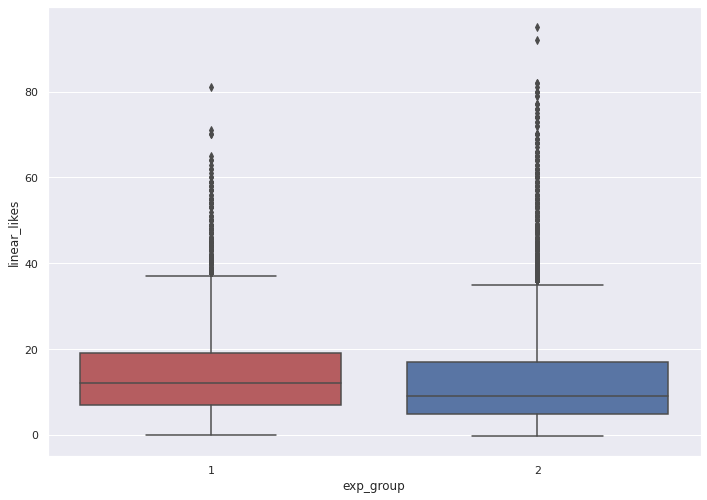

In [50]:
sns.boxplot(data = df, 
              x = 'exp_group', 
              y = 'linear_likes', 
              palette = ['r', 'b'])

<AxesSubplot:xlabel='exp_group', ylabel='ctr'>

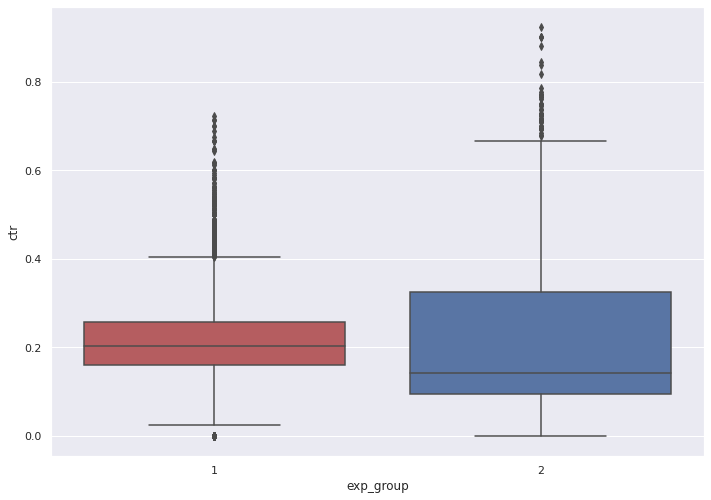

In [51]:
sns.boxplot(data = df, 
              x = 'exp_group', 
              y = 'ctr', 
              palette = ['r', 'b'])

### Проведение теста на новой метрике и ctr в группах 1, 2 показал нам, что по новой метрике p-value существенно выше - есть статистически значимые отличия в тестовой (группа 1) и контрольных группах (группа 2), глазами мы это тоже увидели.

## теперь проделаем тоже самое на группах 0 - контрольной группе и 3 - тестовой группе, возьмем тот же период 2023-05-01 и 2023-05-07 

In [52]:
# выгрузим из кликхауса нужные данные 

q = """
    SELECT 
          exp_group,
          user_id,
          sum(action = 'like') as likes,
          sum(action = 'view') as views,
          likes / views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
            and exp_group in (0, 3)
    GROUP BY exp_group, user_id
    
"""

In [53]:
df_1 = pandahouse.read_clickhouse(q, connection=connection)

In [54]:
df_1.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [55]:
#Убедимся, что юзеров одинаковое +- количество в группах
df_1.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,9999,9999,9999,9999
3,10049,10049,10049,10049


In [56]:
# посчитаем общий CTR в контрольной группе
global_ctr_0 = df_1[df_1.exp_group == 0].likes.sum()/df_1[df_1.exp_group == 0].views.sum()

In [57]:
# посчитаем новую метрику по формуле 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
df_1['linear_likes'] = df_1.likes - global_ctr_0/df_1.views

In [58]:
df_1.head()

,exp_group,user_id,likes,views,ctr,linear_likes
0,3,115383,9,30,0.300000,8.993059
1,3,123580,13,48,0.270833,12.995662
2,0,4944,8,41,0.195122,7.994921
3,0,4504,5,15,0.333333,4.986118
4,0,121508,18,88,0.204545,17.997634


In [59]:
global_ctr_0

0.20823612262916305

In [60]:
#увеличим размер в сиборне
sns.set(rc={'figure.figsize':(11.7,8.27)})

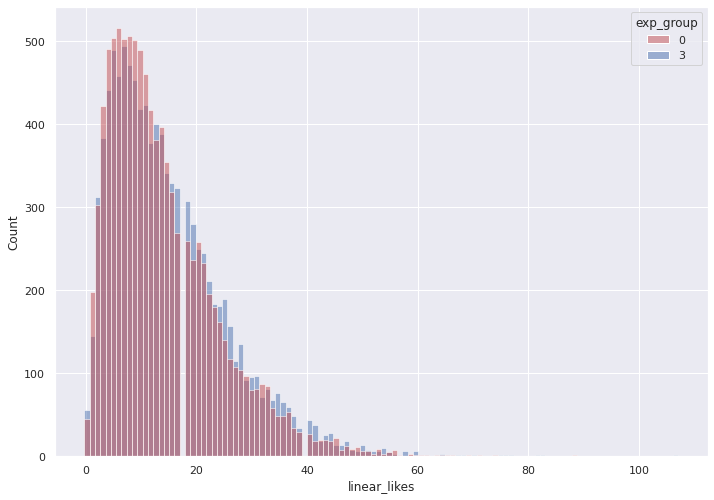

In [61]:
# посмотрим на распределение новой метрики до теста
groups = sns.histplot(data = df_1, 
              x='linear_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

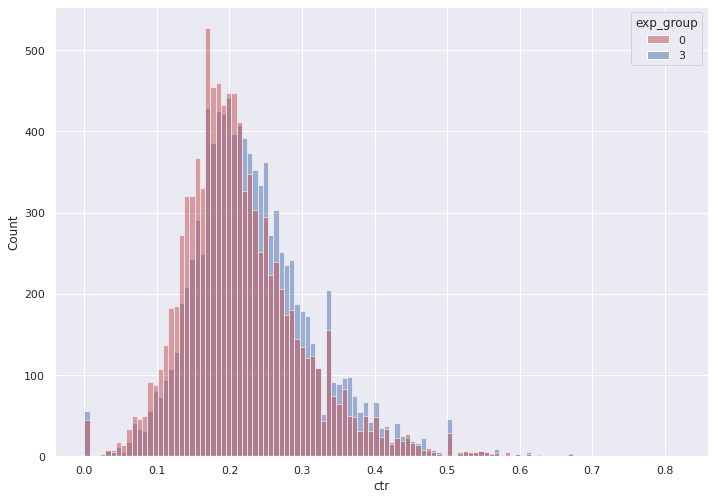

In [65]:
# посмотрим на распределение ctr до теста
groups = sns.histplot(data = df_1, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [63]:
# проведем т-тест
results = stats.ttest_ind(df_1[df_1.exp_group == 0].linear_likes,
                df_1[df_1.exp_group == 3].linear_likes,
                equal_var=False)
print('p-value:', results.pvalue)
print('statistic:', results.statistic)

p-value: 2.069012745066118e-11
statistic: -6.704916938749261


### тест показал что разница в группах есть, p-value высокий, теперь посмотрим на результаты теста на ctr

In [64]:
# проведем т-тест
results = stats.ttest_ind(df_1[df_1.exp_group == 0].ctr,
                df_1[df_1.exp_group == 3].ctr,
                equal_var=False)
print('p-value:', results.pvalue)
print('statistic:', results.statistic)

p-value: 1.055849414662529e-43
statistic: -13.896870721904069


### тест на метрике ctr также показал различия в группах

## Выводы по проделанной работе: 

Сравнение групп 1 - контрольной и 2 - тестовой: тест Стьюдента, проведенный на новой метрике линеаризованных лайков показал статистически значимые отличия в группах, тест на CTR - не показал различий. Отвечая на вопрос из задания уменьшился ли p-value в тесте с новой метрикой - p-value уменьшился. Можно сделать вывод, что т-тест на новой метрике более чувствительный по сравнению с тестом на CTR.

Сравнение групп 0 - контрольной и 3 - тестовой: на обеих метриках т-тест прокрасил статистически значимые отличия в тестовой и контрольной группах